In [19]:
import torch
from PIL import Image
from torchvision.io import read_image
from torchvision.io import ImageReadMode
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from PIL import Image
from torchvision.transforms import (Compose, Normalize, Resize, ToPILImage,
                                    ToTensor)
from tqdm.notebook import tqdm, trange
import numpy as np
import logging
from matplotlib.cm import ScalarMappable
from torchvision import transforms
import torchvision
from matplotlib.colors import Normalize
import random
from datasets import load_dataset

In [171]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if device == 'cpu':
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

mps


In [3]:
def save_tensor_as_image(tensor, filename):
    """
    Saves a single tensor as an image file.

    Args:
        tensor (torch.Tensor): A 2D tensor representing the image.
        filename (str): The path where the image will be saved.
    """
    if tensor.dim() != 2:
        raise ValueError("Input tensor must be 2D.")

    array = tensor.cpu().numpy()
    plt.imsave(filename, array, cmap='gray')

In [4]:
def plot_tensors(tensor, title=None, cmap="magma", show_colorbar=True, save_path=None):
    """
    Plots a batch of filters/images in a nearly square grid.

    The input tensor should have shape (batch_size, filters, height, width).
    Only the first batch element is visualized.

    Args:
        tensor (torch.Tensor or np.ndarray):
            A 4D tensor or array with shape (B, K, H, W).
        title (str, optional):
            Title for the entire grid plot. Defaults to None.
        cmap (str, optional):
            Colormap for visualization. Defaults to "magma".
        show_colorbar (bool, optional):
            Whether to display a shared colorbar. Defaults to True.
        save_path (str, optional):
            File path to save the plot. If None, the plot is not saved.

    Returns:
        None. Displays (and optionally saves) the grid of images.
    """
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().cpu().numpy()

    B, K, H, W = tensor.shape
    imgs = tensor[0]  # (K, H, W)

    vmin, vmax = float(imgs.min()), float(imgs.max())

    # --- cuadrado automático ---
    cols = int(np.ceil(np.sqrt(K)))
    rows = int(np.ceil(K / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axs = np.atleast_2d(axs)

    for i in range(K):
        r, c = divmod(i, cols)
        axs[r, c].imshow(imgs[i], cmap=cmap, vmin=vmin, vmax=vmax)
        axs[r, c].axis("off")

    # Apagar celdas sobrantes
    for j in range(K, rows * cols):
        r, c = divmod(j, cols)
        axs[r, c].axis("off")

    # Colorbar compartida
    if show_colorbar:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        norm = Normalize(vmin=vmin, vmax=vmax)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_ticks([vmin, vmax])

    if title:
        fig.suptitle(title, fontsize=14)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)

    plt.show()
    plt.close()


In [5]:
import torch

def generate_templates(n: int, tau: float = 0.5, beta: float = 4.0):
    """
    Generates n^2 positive templates and one negative template
    for an interpretable CNN, as described in Zhang et al. (2018).

    Each positive template corresponds to a potential spatial position
    in an n x n feature map. Values decay according to the L1 distance
    from the central position. A negative template is also generated
    to represent the absence of activation.

    Args:
        n (int): Size of the feature map (n x n).
        tau (float, optional): Scaling constant for maximum activation value.
            Defaults to 0.5.
        beta (float, optional): Decay factor based on L1 distance.
            Defaults to 4.0.

    Returns:
        tuple:
            templates_pos (list[torch.Tensor]): List of n^2 positive templates
                (each of shape n x n).
            template_neg (torch.Tensor): Negative template of shape n x n
                filled with -tau.

    Example:
        >>> templates_pos, template_neg = generate_templates(4)
        >>> len(templates_pos)
        16
        >>> template_neg.shape
        torch.Size([4, 4])
    """
    templates_pos = []
    coords = [(i, j) for i in range(n) for j in range(n)]

    for mu in coords:
        template = torch.zeros((n, n))
        for i in range(n):
            for j in range(n):
                dist = abs(i - mu[0]) + abs(j - mu[1])  # L1 distance
                value = tau * max(1 - beta * dist / n, -1)
                template[i, j] = value
        templates_pos.append(template)

    template_neg = torch.full((n, n), -tau)

    templates = torch.stack(templates_pos + [template_neg], dim=0)
    return templates


# Quick test
n = 16
templates = generate_templates(n, tau = (0.5/(n*n)), beta=4.0)


In [6]:
templates[[0]].sum()

tensor(-0.4414)

In [7]:
templates.shape

torch.Size([257, 16, 16])

/var/folders/sx/_3f9ftxx24q3hbz_25d1xrjh0000gn/T/ipykernel_25675/2983223761.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


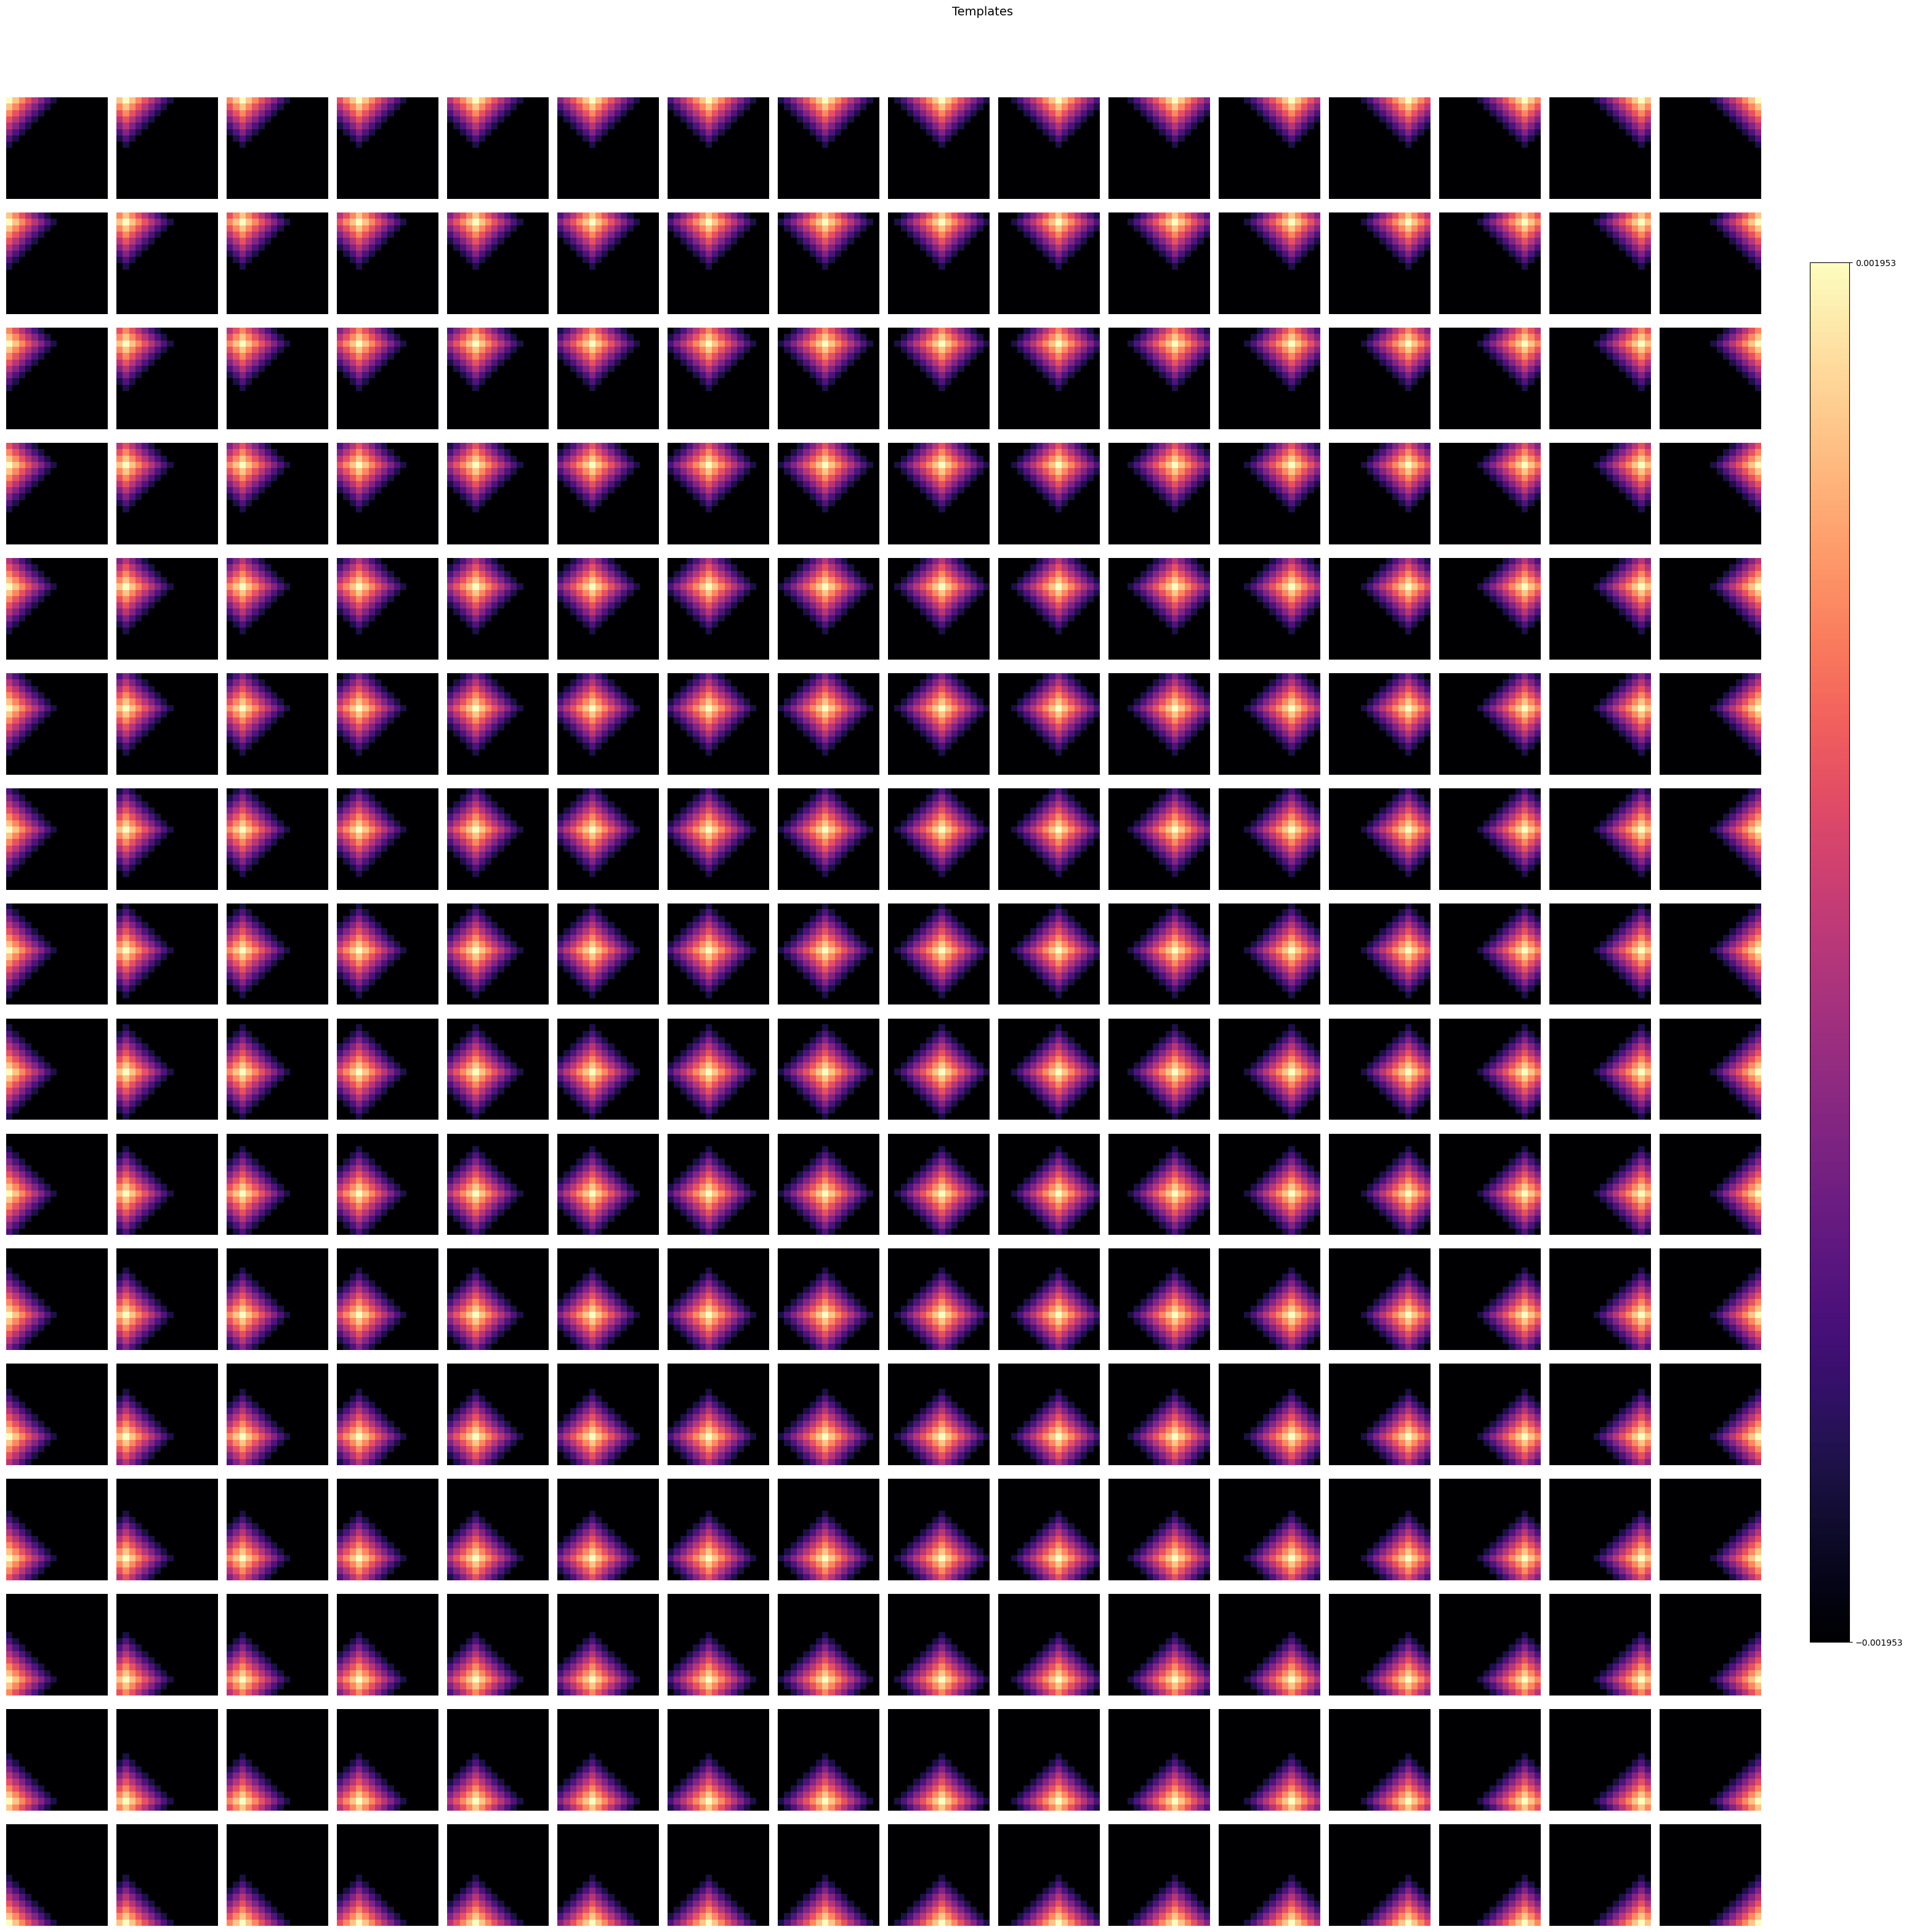

In [8]:
plot_tensors(templates[:-1].unsqueeze(0), title="Templates")

In [9]:
x0 = read_image("./sample_feature_maps/template_16_16_a.png", mode=ImageReadMode.GRAY) / 255.0
x0


RuntimeError: [Errno 2] No such file or directory: './sample_feature_maps/template_16_16_a.png'

In [10]:
x1 = read_image("./sample_feature_maps/template_16_16_b.png", mode=ImageReadMode.GRAY) / 255.0
x1

RuntimeError: [Errno 2] No such file or directory: './sample_feature_maps/template_16_16_b.png'

In [11]:
X = torch.stack([x0, x1], dim=0).squeeze(1)
X.shape

NameError: name 'x0' is not defined

In [12]:
plot_tensors(X.unsqueeze(0), title="Feature Maps")

NameError: name 'X' is not defined

In [13]:
templates[:-1].shape

torch.Size([256, 16, 16])

![image](https://github.com/valentinafeve/interpretability/blob/main/130925/paper.png?raw=1)

In [14]:
T = torch.randn(1, (n*n+1), n, n)
X = torch.randn(5, 2, n, n)

In [15]:
def mutual_information(X: torch.Tensor, templates: torch.Tensor, n, device='cpu'):
    atol = 1/(n*n)
    rtol = 1/(n*n)
    X_expanded = X.unsqueeze(2)
    T_expanded = templates.unsqueeze(1)

    XT = torch.mul(X_expanded, T_expanded)
    s_max = XT.max(dim=-1)[0].max(dim=-1)[0]
    s_min = XT.min(dim=-1)[0].min(dim=-1)[0]
    # print(s_max)
    # print(s_min)
    # XT = XT / s_max.unsqueeze(-1).unsqueeze(-1)
    trace = XT.sum(dim=(-1, -2))
    exp = torch.exp(trace)

    # print(exp.shape)
    ZT = exp.sum(dim=1, keepdim=True)

    pXT = exp / ZT # (2 , 257)

    pT = torch.full((1, (n*n+1)), 1/(1+n*n)).to(device) # (1 , 257)
    pX = ((torch.mul(pXT,pT)).sum(dim=1)) # (2)
    sum_pX = pX.sum(dim=1)
    one = torch.tensor(1.0, device=pT.device, dtype=pT.dtype)
    assert torch.allclose(sum_pX, one, rtol=rtol, atol=atol), "sum_x p(x) debe ser 1"


    eps_box = 1e-7
    assert (pXT >= -eps_box).all() and (pXT <= 1+eps_box).all(), "Valores fuera de [0,1] en p(x|T)"
    assert (pX  >= -eps_box).all() and (pX  <= 1+eps_box).all(), "Valores fuera de [0,1] en p(x)"
    eps = 1e-12
    ratio = pXT.clamp_min(eps) / pX.unsqueeze(1).clamp_min(eps)
    MI = ((pT) * (pXT * torch.log(ratio)).sum(dim=-2)).sum(dim=-1)
    return MI

In [16]:
MI = mutual_information(X, T, X.shape[-1])
MI

tensor([5.5022, 5.4913, 5.5069, 5.4887, 5.4795])

## Preparación de los datos

In [155]:
DESIRED_SHAPE = 64
transform = transforms.Compose(
    [  
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        # transforms.Normalize((0.5), (0.5)),
        transforms.Resize((DESIRED_SHAPE, DESIRED_SHAPE)),
        transforms.CenterCrop((DESIRED_SHAPE, DESIRED_SHAPE)),
        # transforms.ColorJitter(brightness=1.8),
    ]    
    )

batch_size = 5

dataset = load_dataset("Hemg/Melanoma-Cancer-Image-Dataset", split="train")
trainset, testset = dataset.train_test_split(test_size=0.1, seed=42).values()


In [156]:
trainset = trainset.with_format("torch")
testset  = testset.with_format("torch")

In [157]:
trainset[0]

{'image': tensor([[[150, 150, 149,  ..., 149, 131, 134],
          [151, 151, 151,  ..., 127, 127, 152],
          [152, 151, 151,  ..., 121, 137, 123],
          ...,
          [147, 147, 148,  ..., 136, 136, 137],
          [146, 146, 146,  ..., 135, 135, 135],
          [145, 145, 146,  ..., 136, 136, 136]],
 
         [[119, 119, 118,  ..., 122, 104, 107],
          [120, 120, 120,  ..., 100, 100, 125],
          [121, 120, 120,  ...,  94, 110,  96],
          ...,
          [114, 114, 115,  ..., 105, 105, 106],
          [113, 113, 113,  ..., 104, 104, 104],
          [112, 112, 113,  ..., 105, 105, 105]],
 
         [[124, 124, 123,  ..., 127, 109, 112],
          [125, 125, 125,  ..., 105, 105, 130],
          [126, 125, 125,  ...,  99, 115, 101],
          ...,
          [121, 121, 122,  ..., 111, 111, 112],
          [120, 120, 120,  ..., 110, 110, 110],
          [119, 119, 120,  ..., 111, 111, 111]]], dtype=torch.uint8),
 'label': tensor(1)}

In [158]:
trainset = trainset.with_transform(lambda examples: {'image': [transform(img) for img in examples['image']], 'label': examples['label']})

In [159]:
testset = testset.with_transform(lambda examples: {'image': [transform(img) for img in examples['image']], 'label': examples['label']})

In [160]:
testset

Dataset({
    features: ['image', 'label'],
    num_rows: 1188
})

In [161]:
trainset[0]['image']

tensor([[[ 0.1754,  0.1865,  0.1779,  ...,  0.1559,  0.1148,  0.0192],
         [ 0.1543,  0.1750,  0.1776,  ...,  0.1677,  0.0998, -0.2025],
         [ 0.1896,  0.1844,  0.1747,  ...,  0.1802,  0.0843, -0.0538],
         ...,
         [ 0.1505,  0.1734,  0.1791,  ...,  0.1200,  0.1369,  0.1283],
         [ 0.1644,  0.1811,  0.1811,  ...,  0.0984,  0.0918,  0.0854],
         [ 0.1534,  0.1701,  0.1812,  ...,  0.0889,  0.0859,  0.0703]],

        [[-0.0678, -0.0567, -0.0652,  ..., -0.0857, -0.1097, -0.1936],
         [-0.0889, -0.0681, -0.0655,  ..., -0.0738, -0.1248, -0.4153],
         [-0.0535, -0.0587, -0.0684,  ..., -0.0613, -0.1403, -0.2667],
         ...,
         [-0.1083, -0.0854, -0.0798,  ..., -0.1232, -0.1063, -0.1149],
         [-0.0944, -0.0777, -0.0777,  ..., -0.1447, -0.1513, -0.1578],
         [-0.1054, -0.0887, -0.0776,  ..., -0.1542, -0.1572, -0.1729]],

        [[-0.0286, -0.0174, -0.0260,  ..., -0.0394, -0.0703, -0.1544],
         [-0.0496, -0.0289, -0.0263,  ..., -0

In [162]:
classes = trainset.features['label'].names
classes

['Benign', 'Malignant']

In [163]:
print("Dataset loaded with {} classes of values {}".format(len(classes), ', '.join(classes)))
# Dataset loaded with 2 classes of values Benign, Malignant

Dataset loaded with 2 classes of values Benign, Malignant


In [164]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

{'image': tensor([[[[ 5.0997e-02,  1.5767e-01,  2.6184e-01,  ...,  4.1812e-01,
            3.8043e-01,  2.2163e-01],
          [ 1.1605e-01,  2.1657e-01,  3.0667e-01,  ...,  5.2363e-01,
            4.6877e-01,  2.9509e-01],
          [ 2.3308e-01,  2.7947e-01,  3.5229e-01,  ...,  5.8076e-01,
            5.1283e-01,  3.1682e-01],
          ...,
          [ 2.6528e-01,  3.0907e-01,  4.1959e-01,  ...,  5.8251e-01,
            5.1117e-01,  3.4972e-01],
          [ 2.4965e-01,  2.8348e-01,  3.6404e-01,  ...,  5.6000e-01,
            4.9067e-01,  3.5692e-01],
          [ 2.2766e-01,  2.5395e-01,  2.7361e-01,  ...,  2.8501e-01,
            2.2405e-01,  1.1951e-01]],

         [[-1.5921e-01, -9.4592e-02, -2.5061e-02,  ...,  1.0473e-01,
            1.4831e-01,  7.3382e-02],
          [-1.2564e-01, -6.5582e-02, -5.8652e-03,  ...,  1.2027e-01,
            1.4556e-01,  5.0147e-02],
          [-5.8124e-02, -5.1500e-02, -5.5908e-03,  ...,  1.9188e-01,
            2.0069e-01,  8.0793e-02],
          

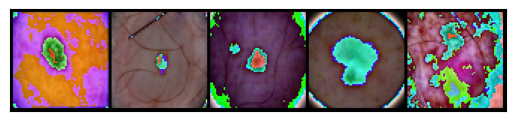

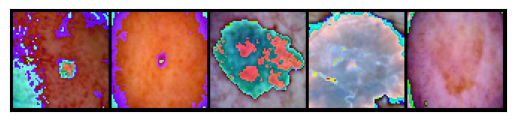

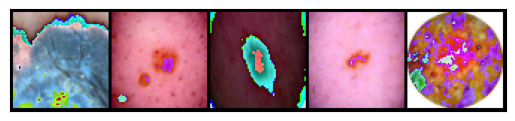

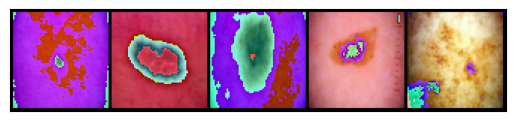

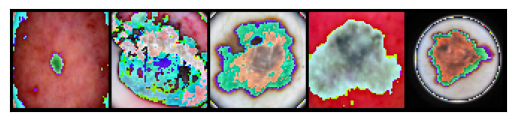

In [172]:
cont = 0
for batch in trainloader:
    print(batch)
    print(batch['image'].shape)
    show(torchvision.utils.make_grid(batch['image']))
    print(batch['label'])
    cont+=1
    if cont==5:
        break

## Definición del modelo

In [173]:
class InterpretableConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, feature_map_size, tau=0.5, beta=4.0, alpha=0.95):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=True)
        self.tau = tau
        self.beta = beta
        self.alpha = alpha
        self.n = feature_map_size
        self.templates = generate_templates(self.n, tau=self.tau, beta=self.beta)

    def forward(self, x):
        x = nn.ReLU()(self.conv(x))
        if not self.training:
            logging.info("Training mode: applying masks to feature maps.")
            masks = self._assign_masks(x)
            masked_x = x * masks
            return masked_x * (masked_x > 0)
        else:
            logging.info("Inference mode: applying templates to feature maps.")
            return x

    def _assign_masks(self, x):

        B, C, H, W = x.shape

        x_flat = x.view(B * C, H, W)
        masks = []

        for fmap in x_flat:
            mu_hat = torch.argmax(fmap.view(-1))
            i, j = mu_hat // self.n, mu_hat % self.n
            idx = i * self.n + j
            mask = self.templates[idx]
            masks.append(mask)

        masks = torch.stack(masks).view(B, C, H, W).to(x.device)
        return masks

In [178]:
OUTPUT_CHANNELS = len(classes)
INPUT_CHANNELS = X.shape[1]
icnn = InterpretableConvLayer(in_channels=INPUT_CHANNELS, out_channels=OUTPUT_CHANNELS, kernel_size=3, feature_map_size=n, tau=(0.5/(n*n)), beta=4.0)
icnn = icnn.to(device)
icnn

InterpretableConvLayer(
  (conv): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [179]:
output = icnn(X.to(device))
output.shape

torch.Size([5, 2, 16, 16])

In [208]:
class Model(nn.Module):
    def __init__(self, feature_map_size, channels=1, num_classes=10, filters_icnn=6):
        super().__init__()
        filters_cnn=20
        self.cnn = nn.Conv2d(channels, filters_cnn, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.icnn = InterpretableConvLayer(in_channels=filters_cnn, out_channels=filters_icnn, kernel_size=3, feature_map_size=feature_map_size//2, tau=2.00, beta=4.00, alpha=4.00)
        # self.cnn2 = nn.Conv2d(filters_cnn, filters_icnn, kernel_size=3, padding=1)

        input_size = filters_icnn * (feature_map_size // 4) * (feature_map_size // 4)
        self.linear = nn.Linear(3072, 100)
        self.classifier = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = self.pool(x)
        x = nn.ReLU()(x)
        x = self.icnn(x)
        # x = self.cnn2(x)
        x = nn.ReLU()(x)
        icnn_output = x
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = nn.ReLU()(x)
        logits = self.classifier(x)
        # x = torch.softmax(x, dim=1)
        return logits, icnn_output


## Training

In [209]:
INPUT_CHANNELS = 3

In [210]:
n = trainset[0]['image'].shape[-1]
print("Feature map size n =", n)
model = Model(feature_map_size=n, channels=INPUT_CHANNELS, num_classes=len(classes), filters_icnn=12)

Feature map size n = 64


In [211]:
trainset[0]['image'].unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

## Entrenamiento del modelo

In [213]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-1)
criterion = nn.CrossEntropyLoss()

In [214]:
n

64

In [215]:
lambda_ = 1e-2
EPOCHS = 40

losses = {
    "total_loss": [],
    "class_loss": [],
    "interp_loss": []
}

model = Model(feature_map_size=n, channels=3, num_classes=len(classes), filters_icnn=12)
model = model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

# keep_icnn_output = 0
# keep_templates = 0
for epoch in trange(EPOCHS):
    losses_epoch = {
        "total_loss": [],
        "class_loss": [],
        "interp_loss": []
    }
    for batch in tqdm(trainloader, desc="Training", leave=False):

        optimizer.zero_grad()
        images, labels = batch['image'].to(device), batch['label'].to(device)
        logits, icnn_output = model(images)

        # print(y_pred.shape, labels.shape)
        # print(labels, "labels")
        # print(y_pred, "y pred")
        class_loss = criterion(logits, labels.long())
        # print(y_pred)


        # batch_size = images.shape[0]
        # templates = model.icnn.templates.unsqueeze(0).to(device)

        # keep_icnn_output = icnn_output.detach().clone()
        # keep_templates = templates.detach().clone()

        # print("icnn output", icnn_output.shape)
        # print("templates", templates.shape)
        # interp_loss = mutual_information(icnn_output, templates, icnn_output.shape[-1], device=device).sum()
        # total_loss = lambda_ * interp_loss + (1 - lambda_) * class_loss
        # total_loss = class_loss
        # print("Interp loss", lambda_ * interp_loss.item())
        # print("Total loss", total_loss.item())

        # losses["class_loss"].append(class_loss.item())
        losses_epoch["class_loss"].append(class_loss.item())

        class_loss.backward()
        optimizer.step()
        # break

    avg_loss = np.mean(losses_epoch["class_loss"])
    print(f"Epoch {epoch+1}/{EPOCHS}, Avg Class Loss: {avg_loss:.4f}")
    # avg_interp_loss = np.mean(losses_epoch["interp_loss
    # print(np.mean(losses["class_loss"]))
    print(class_loss)
    # print(interp_loss)
    # losses["total_loss"].append(total_loss.item())
    losses["class_loss"].append(avg_loss)
    # losses["interp_loss"].append(interp_loss.item())


  0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 1/40, Avg Class Loss: 0.3857
tensor(1.1073, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 2/40, Avg Class Loss: 0.3358
tensor(0.0022, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 3/40, Avg Class Loss: 0.3155
tensor(0.0006, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 4/40, Avg Class Loss: 0.3017
tensor(0.1274, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 5/40, Avg Class Loss: 0.2925
tensor(0.2544, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 6/40, Avg Class Loss: 0.2807
tensor(0.0007, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 7/40, Avg Class Loss: 0.2684
tensor(0.4392, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 8/40, Avg Class Loss: 0.2649
tensor(0.0047, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 9/40, Avg Class Loss: 0.2585
tensor(0.0253, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 10/40, Avg Class Loss: 0.2498
tensor(0.0075, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 11/40, Avg Class Loss: 0.2433
tensor(0.2076, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 12/40, Avg Class Loss: 0.2347
tensor(0.0024, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 13/40, Avg Class Loss: 0.2263
tensor(0.0009, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 14/40, Avg Class Loss: 0.2243
tensor(0.0019, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 15/40, Avg Class Loss: 0.2183
tensor(0.9184, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 16/40, Avg Class Loss: 0.2145
tensor(0.0009, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 17/40, Avg Class Loss: 0.2062
tensor(0.0166, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 18/40, Avg Class Loss: 0.1999
tensor(0.0600, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 19/40, Avg Class Loss: 0.1952
tensor(1.1921e-07, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 20/40, Avg Class Loss: 0.1941
tensor(0.0001, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 21/40, Avg Class Loss: 0.1856
tensor(0.1831, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 22/40, Avg Class Loss: 0.1849
tensor(0.2037, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 23/40, Avg Class Loss: 0.1795
tensor(2.2098, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 24/40, Avg Class Loss: 0.1754
tensor(0.0556, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 25/40, Avg Class Loss: 0.1740
tensor(0.1728, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 26/40, Avg Class Loss: 0.1635
tensor(0.0034, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 27/40, Avg Class Loss: 0.1637
tensor(0.1476, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 28/40, Avg Class Loss: 0.1624
tensor(0.0001, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 29/40, Avg Class Loss: 0.1554
tensor(2.9802e-06, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 30/40, Avg Class Loss: 0.1531
tensor(1.1921e-07, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 31/40, Avg Class Loss: 0.1520
tensor(0.0015, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 32/40, Avg Class Loss: 0.1459
tensor(0.0006, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 33/40, Avg Class Loss: 0.1447
tensor(7.1525e-06, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 34/40, Avg Class Loss: 0.1418
tensor(0.0084, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 35/40, Avg Class Loss: 0.1416
tensor(1.0144, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 36/40, Avg Class Loss: 0.1392
tensor(0.0308, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 37/40, Avg Class Loss: 0.1330
tensor(0.0515, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 38/40, Avg Class Loss: 0.1350
tensor(0.0046, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 39/40, Avg Class Loss: 0.1321
tensor(0.4035, device='mps:0', grad_fn=<NllLossBackward0>)


Training:   0%|          | 0/2139 [00:00<?, ?it/s]

Epoch 40/40, Avg Class Loss: 0.1344
tensor(1.3113e-06, device='mps:0', grad_fn=<NllLossBackward0>)


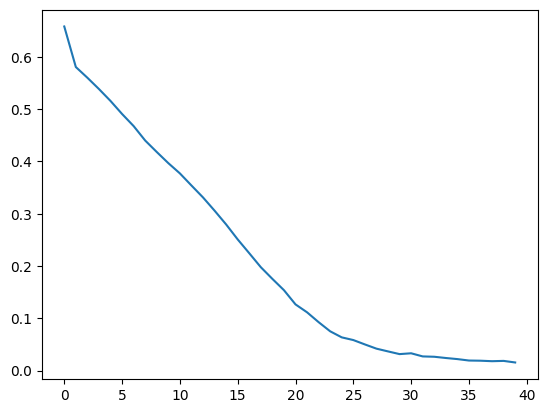

In [ ]:
# plt.plot(losses["total_loss"], label="Total Loss")
plt.plot(losses["class_loss"], label="Class Loss")
# plt.plot(losses["interp_loss"], label="Interp Loss")

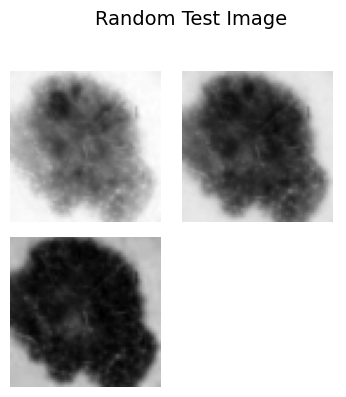

In [217]:
rand_i = random.randint(0, len(testset)-1)
rand_item = testset[rand_i]["image"].unsqueeze(0)
rand_item.shape
plot_tensors(rand_item, title="Random Test Image", cmap="gray", show_colorbar=False)

In [218]:
icnn_filters = model.icnn.conv.weight.data
icnn_filters.shape

torch.Size([12, 20, 3, 3])

In [219]:
logits, icnn_output = model(rand_item.to(device))
icnn_output.shape

torch.Size([1, 12, 32, 32])

/var/folders/sx/_3f9ftxx24q3hbz_25d1xrjh0000gn/T/ipykernel_25675/2983223761.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


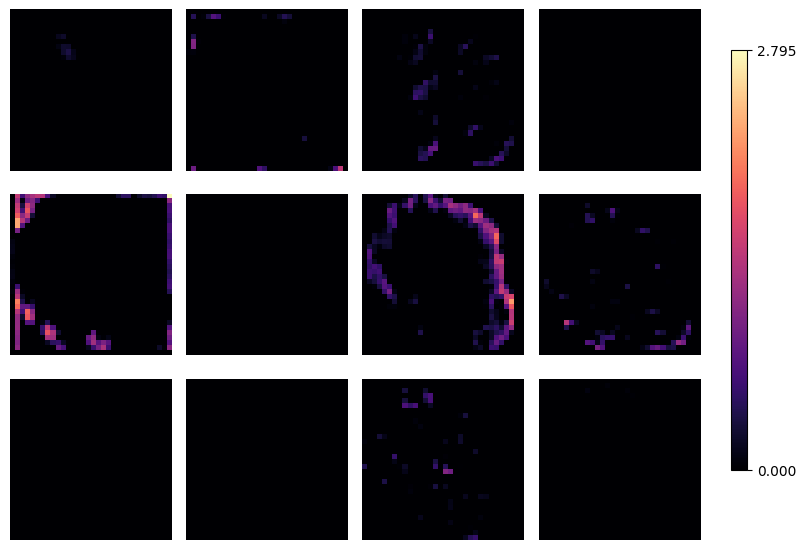

In [220]:
plot_tensors(icnn_output)

In [222]:
# Evaluate
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in testloader:
        images, labels = batch['image'].to(device), batch['label'].to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # print(predicted)
        # print(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

Accuracy of the model on the 1188 test images: 75.33670033670033 %
